In [5]:
import json

from pathlib import Path
from typing import Optional, Dict, List
import matplotlib.pyplot as plt

BENCHMARK_PATH = Path('').resolve().parent / 'benchmark'
RESULTS_PATH = BENCHMARK_PATH / 'results.json'
results = json.load(open(RESULTS_PATH))
benchmarks = results['benchmarks']

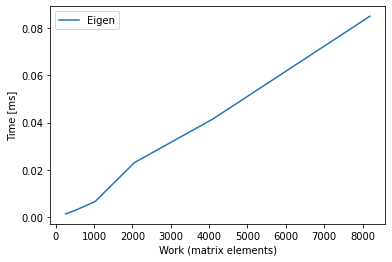

In [6]:
def plot_eigen_wt(ax: Optional[plt.Axes] = None):
    if ax is None:
        _, ax = plt.subplots()
    r = {
        int(run[2]): b['real_time']
        for b in benchmarks if (run := b['name'].split('/'))[1] == 'Eigen'
        }
    ax.plot(
        r.keys(),
        r.values(),
        label='Eigen',
        )
    ax.set_xlabel('Work (matrix elements)')
    ax.set_ylabel('Time [ms]')
    ax.legend()

plot_eigen_wt()

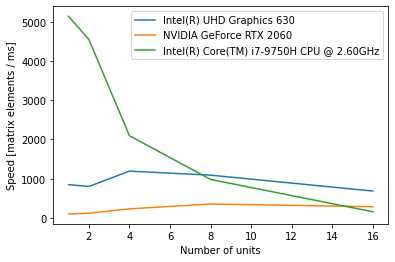

In [11]:
def plot_opencl_us(devices: Dict[int, str], ax: Optional[plt.Axes] = None):
    if ax is None:
        _, ax = plt.subplots()
    devices_list = list(devices.keys())
    r = {}
    for b in benchmarks:
        if (
            not (run := b['name'].split('/'))[1] == 'OpenCL'
            and not b.get('errors_ocurred', False)
            ):
            continue
        elif 0 > (device_num := int(run[2])) > devices.len():
            continue
        unit = int(run[3])
        device = devices_list[device_num]
        work = unit * devices[device]
        r.setdefault(device, {})[unit] = work / b['real_time']
    for device, d in r.items():
        ax.plot(
            d.keys(),
            d.values(),
            label=f'{device}',
            )
    ax.set_xlabel('Number of units')
    ax.set_ylabel('Speed [matrix elements / ms]')
    ax.legend()


_, ax = plt.subplots()
plot_opencl_us({
    "Intel(R) UHD Graphics 630": 256,
    "NVIDIA GeForce RTX 2060": 256,
    "Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz": 8192
    }, ax)